**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2
import tensorflow as tf
#tf.enable_eager_execution()
tf.VERSION


'1.12.0'

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [4]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)): # in total 7 levels zoom
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

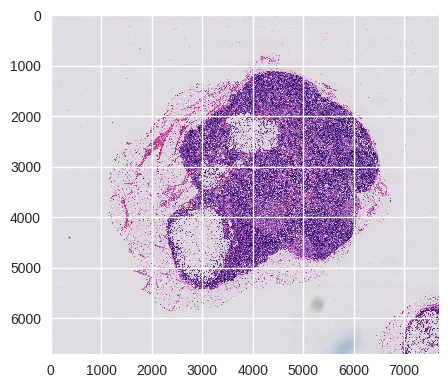

In [6]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)

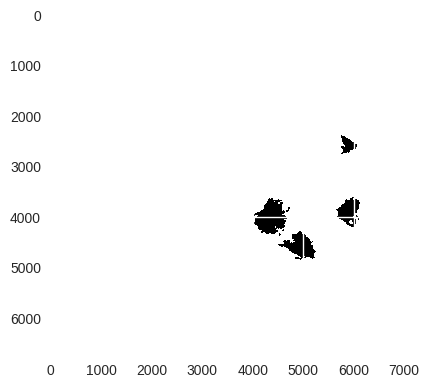

In [7]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide.level_dimensions[3][0], 
                        height=slide.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]
#print(mask_image.shape)
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

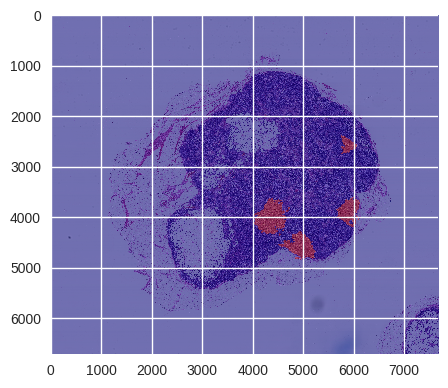

In [8]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

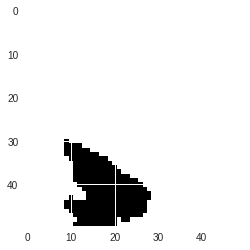

In [9]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

In [0]:
(w_width, w_height) = (40, 40)

def sliding_window(image, stepSize=40, windowSize=(w_width, w_height)):
	# slide a window across the image
	for x in range(0, image.shape[0]-w_width, stepSize):
		for y in range(0, image.shape[1]-w_height, stepSize):
			# yield the current window
			yield (x, y), image[x:x + w_width, y:y + w_height]

In [55]:
X_indices, X_patches = zip(*sliding_window(slide_image))

X_train = np.array([patch for patch in X_patches])
assert X_train.shape[0] == len(X_indices)
print(X_train.shape)


(31897, 40, 40, 3)


In [0]:
# import cv2
# # draw rectangle on image
# cv2.rectangle(slide_image, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2) 
# plt.imshow(np.array(slide_image).astype('uint8'))

In [56]:
import math
y_indices, y_patches = zip(*sliding_window(mask_image))
y_train = np.array([math.ceil(np.mean(patch)) for patch in y_patches])
print(y_train.shape)

(31897,)


In [0]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_patches, y_patches, test_size=0.2)

## Getting another image

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# 
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
slide_id = '1tCvyQIXadK0TSJlrwmkQ38caD1HsjevQ'
slideFile = drive.CreateFile({'id': slide_id})
mask_id = '1jZKrrj-mat0J_ur0CNhkeoYD1Fu-DtJu'
maskFile = drive.CreateFile({'id': mask_id})


In [18]:
print('Created file %s with mimeType %s' % (slideFile['title'], slideFile['mimeType']))
print('Created file %s with mimeType %s' % (maskFile['title'], maskFile['mimeType']))

Created file tumor_110.tif with mimeType image/tiff
Created file tumor_110_mask.tif with mimeType image/tiff


In [0]:
slideFile.GetContentFile("tumor_110.tif")
maskFile.GetContentFile("tumor_110_mask.tif")

In [20]:
slide2 = open_slide("tumor_110.tif")

tumor_mask2 = open_slide("tumor_110_mask.tif")
print("slide level", len(slide2.level_dimensions))
print("tumor level", len(tumor_mask2.level_dimensions))
for i in range(len(tumor_mask2.level_dimensions)): # in total 7 levels zoom
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide2.level_dimensions[i], 
                                                             slide2.level_downsamples[i]))
    assert tumor_mask2.level_dimensions[i][0] == slide2.level_dimensions[i][0]
    assert tumor_mask2.level_dimensions[i][1] == slide2.level_dimensions[i][1]

# Verify downsampling works as expected

width, height = slide2.level_dimensions[7]
assert width * slide2.level_downsamples[7] == slide2.level_dimensions[0][0]
assert height * slide2.level_downsamples[7] == slide2.level_dimensions[0][1]

('slide level', 9)
('tumor level', 9)
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


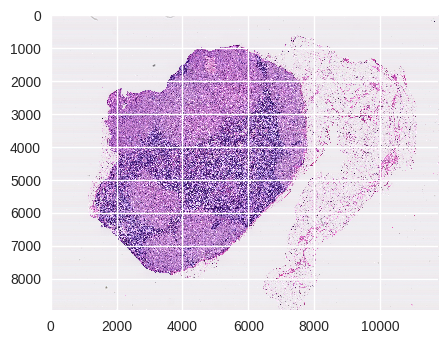

In [25]:
slide_image2 = read_slide(slide2, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide2.level_dimensions[3][0], 
                         height=slide2.level_dimensions[3][1])

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image2)

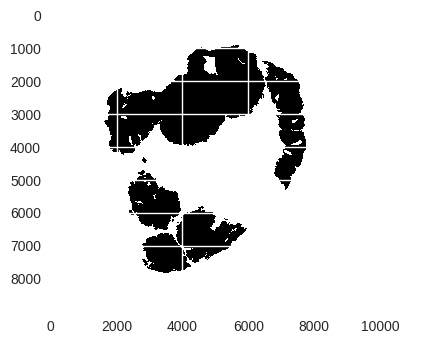

In [26]:
mask_image2 = read_slide(tumor_mask2, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide2.level_dimensions[3][0], 
                        height=slide2.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image2 = mask_image2[:,:,0]
#print(mask_image.shape)
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image2)

In [57]:
X_indices_, X_patches_ = zip(*sliding_window(slide_image2))

X_test = np.array([patch for patch in X_patches_])
assert X_test.shape[0] == len(X_indices_)
print(X_test.shape)


(65562, 40, 40, 3)


In [58]:
import math
y_indices_, y_patches_ = zip(*sliding_window(mask_image2))
y_test = np.array([math.ceil(np.mean(patch)) for patch in y_patches_])
print(y_test.shape)

(65562,)


# Oversampling on the postive class
For comparison.

In [63]:
minority_indices = np.where(y_train==1)[0]
majority_count = (y_train==0).sum()
print(majority_count)
print(len(minority_indices))

31271
626


In [0]:
#oversampling
sample_indices = np.random.choice(minority_indices, size=majority_count, replace=True)
X_sample = np.append(X_train[sample_indices], X_train[np.where(y_train==0)], axis=0)
y_sample = np.append(y_train[sample_indices], y_train[np.where(y_train==0)])

In [0]:
# shuffling 
new_indices = np.arange(X_sample.shape[0])
#print(new_indices)
np.random.shuffle(new_indices)
#print(new_indices)
X_sample = X_sample[new_indices]
y_sample = y_sample[new_indices]

In [66]:
print(X_sample.shape)

(62542, 40, 40, 3)


In [67]:
print(y_sample.shape, y_test.shape)
#(y_test==1).sum()

((62542,), (65562,))


In [0]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False, input_shape=(40, 40, 3))
conv_base.trainable = False
#conv_base.summary()

In [69]:
model = tf.keras.Sequential([
  conv_base,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')])

model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 14,780,610
Trainable params: 65,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [70]:
model.fit(X_sample, y_sample, epochs=10, batch_size=32, validation_split=0.1)

Train on 56287 samples, validate on 6255 samples
Epoch 1/10
56287/56287 [==============================] - 48s 860us/step - loss: 0.2911 - acc: 0.9306 - val_loss: 0.1359 - val_acc: 0.9680
Epoch 2/10
56287/56287 [==============================] - 47s 831us/step - loss: 0.1259 - acc: 0.9674 - val_loss: 0.1139 - val_acc: 0.9762
Epoch 3/10
56287/56287 [==============================] - 47s 832us/step - loss: 0.1045 - acc: 0.9750 - val_loss: 0.1270 - val_acc: 0.9727
Epoch 4/10
56287/56287 [==============================] - 47s 832us/step - loss: 0.0836 - acc: 0.9832 - val_loss: 0.1165 - val_acc: 0.9770
Epoch 5/10
56287/56287 [==============================] - 47s 832us/step - loss: 0.0730 - acc: 0.9867 - val_loss: 0.1006 - val_acc: 0.9813
Epoch 6/10
56287/56287 [==============================] - 47s 831us/step - loss: 0.0712 - acc: 0.9870 - val_loss: 0.0774 - val_acc: 0.9899
Epoch 7/10
56287/56287 [==============================] - 47s 832us/step - loss: 0.0631 - acc: 0.9898 - val_loss: 0.0

In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score

scores = model.evaluate(X_test, y_test)

print 'Loss: ', scores[0]
print'Accuracy: ', scores[1]

65562/65562 [==============================] - 48s 734us/step
Loss:  1.0456185865664862
Accuracy:  0.9003843689942345


In [72]:
y_predict = model.predict(X_test)
#y_predict_label = y_predict.argmax(axis=1)
y_predict_label = model.predict_classes(X_test)

print 'Precision:', precision_score(y_test, y_predict_label)
print 'Recall:', recall_score(y_test, y_predict_label)
print 'F1:', f1_score(y_test, y_predict_label)

Precision: 0.9509954058192955
Recall: 0.44187494440985503
F1: 0.6033885953725633


## Using only pixel region

13344403 tissue_pixels pixels (29.6 percent of the image)


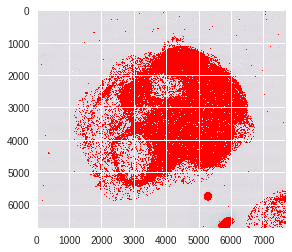

In [74]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [75]:
tissue_regions.shape

(6720, 7680, 3)

In [76]:
tissue_regions[0][0]

array([222, 220, 225], dtype=uint8)

In [0]:
# (w_width, w_height) = (224, 224)

# def sliding_region(image, stepSize=224, windowSize=(w_width, w_height)):
# 	# slide a window across the image
# 	for x in range(0, image.shape[0]-w_width, stepSize):
# 		for y in range(0, image.shape[1]-w_height, stepSize):
# 			# yield the current window
# 			for i in range(x, x+w_width):
# 				for j in range(y, y+w_height):
# 					if image[i][j] == (255,0,0):
# 			yield image[x:x + w_width, y:y + w_height]

In [0]:
# X_patches = zip(*sliding_region(tissue_regions))

# X_patches = np.array([patch for patch in X_patches])

# print(X_patches.shape)
# (986, 224, 224, 3)

In [0]:
def get_tissue(X_indices, X_patches):
  X_region = []
  y_region = []
  for idx, (x, y) in enumerate(X_indices):
    img = X_patches[idx]
    for i in range(x, x+img.shape[0]):
      for j in range(y, y+img.shape[1]):
      
        if (tissue_regions[i][j] == np.array([255,0,0])).all():
          X_region.append(img)
          y_region.append(y_patches[idx])
          break
      else:
        continue
      break
  
  X_region = np.array(X_region)
  y_region = np.array(y_region)
  return (X_region, y_region)


In [87]:
(X_train, y_train) = get_tissue(X_indices, X_train)
#X_test, y_test = get_tissue(X_test)

print(X_train.shape, y_train.shape)     

((15884, 40, 40, 3), (15884, 40, 40))


In [0]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_region, y_region, test_size=0.2)

In [88]:
minority_indices = np.where(y_train==1)[0]
majority_count = (y_train==0).sum()
print(majority_count)
print(len(minority_indices))

24666188
748212


In [0]:
#oversampling
sample_indices = np.random.choice(minority_indices, size=majority_count, replace=True)
X_sample = np.append(X_train[sample_indices], X_train[np.where(y_train==0)], axis=0)
y_sample = np.append(y_train[sample_indices], y_train[np.where(y_train==0)])

In [0]:
# shuffling 
new_indices = np.arange(X_sample.shape[0])
#print(new_indices)
np.random.shuffle(new_indices)
#print(new_indices)
X_sample = X_sample[new_indices]
y_sample = y_sample[new_indices]

In [0]:
print(y_train.shape, y_test.shape)
(y_test==1).sum()

((752,), (189,))


9

In [0]:
model_ = tf.keras.Sequential([
  conv_base,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')])

model_.compile(optimizer = tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['acc'])
model_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                16416     
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 66        
Total params: 14,731,170
Trainable params: 16,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model_.fit(X_sample, y_sample, epochs=10, batch_size=32, validation_split=0.1)

Train on 1297 samples, validate on 145 samples
Epoch 1/10
1297/1297 [==============================] - 27s 21ms/step - loss: 0.8110 - acc: 0.8180 - val_loss: 0.2196 - val_acc: 0.9034
Epoch 2/10
1297/1297 [==============================] - 14s 11ms/step - loss: 0.1444 - acc: 0.9514 - val_loss: 0.1451 - val_acc: 0.9379
Epoch 3/10
1297/1297 [==============================] - 14s 11ms/step - loss: 0.0822 - acc: 0.9776 - val_loss: 0.1005 - val_acc: 0.9655
Epoch 4/10
1297/1297 [==============================] - 14s 11ms/step - loss: 0.0603 - acc: 0.9846 - val_loss: 0.0836 - val_acc: 0.9793
Epoch 5/10
1297/1297 [==============================] - 14s 11ms/step - loss: 0.0465 - acc: 0.9884 - val_loss: 0.0993 - val_acc: 0.9517
Epoch 6/10
1297/1297 [==============================] - 14s 11ms/step - loss: 0.0371 - acc: 0.9907 - val_loss: 0.0852 - val_acc: 0.9586
Epoch 7/10
1297/1297 [==============================] - 14s 11ms/step - loss: 0.0304 - acc: 0.9915 - val_loss: 0.0641 - val_acc: 0.9793
E

In [0]:
scores = model_.evaluate(X_test, y_test)

print 'Loss: ', scores[0]
print'Accuracy: ', scores[1]

189/189 [==============================] - 2s 9ms/step
Loss:  0.058013359311396485
Accuracy:  0.9682539717230216


In [0]:
y_predict = model_.predict(X_test)
y_predict_label = y_predict.argmax(axis=1)

print 'Precision:', precision_score(y_test, y_predict_label)
print 'Recall:', recall_score(y_test, y_predict_label)
print 'F1:', f1_score(y_test, y_predict_label)

Precision: 0.6153846153846154
Recall: 0.8888888888888888
F1: 0.7272727272727274


## Heatmap

## Inception Model and fine tuning

In [0]:
inception = tf.keras.applications.inception_v3.InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = None)

inception.trainable = False

In [0]:
model_inception = tf.keras.Sequential([
    inception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])
model_inception.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model_inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 258       
Total params: 22,065,314
Trainable params: 262,530
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model_inception.fit(X_sample, y_sample, epochs=10, batch_size=32, validation_split=.1)


Train on 1297 samples, validate on 145 samples
Epoch 1/10
1297/1297 [==============================] - 59s 46ms/step - loss: 0.5101 - acc: 0.7803 - val_loss: 0.7629 - val_acc: 0.6138
Epoch 2/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.3390 - acc: 0.8504 - val_loss: 0.9411 - val_acc: 0.6138
Epoch 3/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.3735 - acc: 0.8389 - val_loss: 1.1145 - val_acc: 0.6138
Epoch 4/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.3179 - acc: 0.8712 - val_loss: 0.9870 - val_acc: 0.6138
Epoch 5/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.3314 - acc: 0.8566 - val_loss: 0.8436 - val_acc: 0.6138
Epoch 6/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.3133 - acc: 0.8697 - val_loss: 0.5797 - val_acc: 0.6276
Epoch 7/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.2842 - acc: 0.8790 - val_loss: 0.4105 - val_acc: 0.7655
Epoch 8/10
12

In [0]:
scores = model_inception.evaluate(X_test, y_test)
print(scores)
print 'Loss: ', scores[0]
print'Accuracy: ', scores[1]

189/189 [==============================] - 1s 6ms/step
[0.7598842445504729, 0.6878306868845824]
Loss:  0.7598842445504729
Accuracy:  0.6878306868845824


In [0]:
y_predict = model_inception.predict(X_test)
y_predict_label = y_predict.argmax(axis=1)

print 'Precision:', precision_score(y_test, y_predict_label)
print 'Recall:', recall_score(y_test, y_predict_label)
print 'F1:', f1_score(y_test, y_predict_label)

Precision: 0.1323529411764706
Recall: 1.0
F1: 0.23376623376623376


##Fine Tuning

In [0]:

inception.trainable = True

# i = 0
# while inception.layers[i].name.startswith('mixed8') == False:
#   inception.layers[i].trainable = False
#   i += 1

for layer in inception.layers[:249]:
  layer.trainable=False
for layer in inception.layers[249:]:
  layer.trainable=True

#inception.summary()

In [0]:
# model_inception = tf.keras.Sequential([
#     inception,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dense(2, activation = 'softmax')
# ])

# model_inception.compile(optimizer=tf.train.AdamOptimizer(), 
#               loss=tf.keras.losses.sparse_categorical_crossentropy,
#               metrics=["accuracy"])

#from tf.keras.optimizers import SGD
model_inception.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model_inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 258       
Total params: 22,065,314
Trainable params: 11,377,410
Non-trainable params: 10,687,904
_________________________________________________________________


In [0]:
model_inception.fit(X_sample, y_sample, epochs=10, batch_size=32, validation_split=.1)

Train on 1297 samples, validate on 145 samples
Epoch 1/10
1297/1297 [==============================] - 64s 49ms/step - loss: 0.3128 - acc: 0.8736 - val_loss: 0.2956 - val_acc: 0.8690
Epoch 2/10
1297/1297 [==============================] - 11s 8ms/step - loss: 0.2207 - acc: 0.9113 - val_loss: 0.2901 - val_acc: 0.8759
Epoch 3/10
1297/1297 [==============================] - 11s 8ms/step - loss: 0.1948 - acc: 0.9206 - val_loss: 0.2950 - val_acc: 0.8759
Epoch 4/10
1297/1297 [==============================] - 11s 8ms/step - loss: 0.2113 - acc: 0.9175 - val_loss: 0.2837 - val_acc: 0.8759
Epoch 5/10
1297/1297 [==============================] - 11s 8ms/step - loss: 0.1930 - acc: 0.9260 - val_loss: 0.2783 - val_acc: 0.8759
Epoch 6/10
1297/1297 [==============================] - 11s 8ms/step - loss: 0.1792 - acc: 0.9406 - val_loss: 0.2626 - val_acc: 0.8759
Epoch 7/10
1297/1297 [==============================] - 11s 8ms/step - loss: 0.1890 - acc: 0.9237 - val_loss: 0.2622 - val_acc: 0.8759
Epoch 8

In [0]:
scores = model_inception.evaluate(X_test, y_test)
print(scores)
print 'Loss: ', scores[0]
print'Accuracy: ', scores[1]

189/189 [==============================] - 1s 6ms/step
[0.24578097036906651, 0.8518518531133258]
Loss:  0.24578097036906651
Accuracy:  0.8518518531133258


In [0]:
y_predict = model_inception.predict(X_test)
y_predict_label = y_predict.argmax(axis=1)

print 'Precision:', precision_score(y_test, y_predict_label)
print 'Recall:', recall_score(y_test, y_predict_label)
print 'F1:', f1_score(y_test, y_predict_label)

Precision: 0.1724137931034483
Recall: 0.5555555555555556
F1: 0.26315789473684215


## Data Augmentation

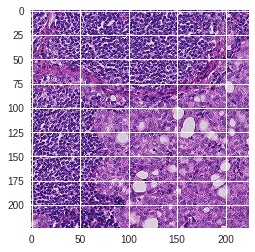

In [0]:
sample_patch = X_sample[134]

plt.imshow(sample_patch)


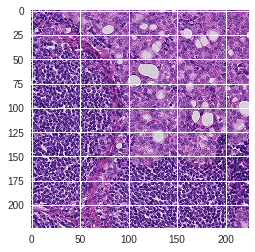

In [0]:
from scipy.ndimage import rotate
patch_rotated = rotate(sample_patch, 90)
plt.imshow(patch_rotated)

In [0]:
def rotate_img(patches):
  new_patches = []
  for patch in patches:
    new_patch = rotate(patch,90)
    new_patches.append(new_patch)
  new_patches = np.array(new_patches)
  return new_patches
  
new_patches = rotate_img(X_sample)
    
    

In [0]:
X_sample_r = new_patches

In [0]:
inception = tf.keras.applications.inception_v3.InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

inception.trainable = False

In [0]:
model_inception_1 = tf.keras.Sequential([
    inception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

model_inception_1.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

#from tf.keras.optimizers import SGD
model_inception_1.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model_inception_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_20  (None, 2048)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 130       
Total params: 21,934,050
Trainable params: 131,266
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model_inception_1.fit(X_sample_r, y_sample, batch_size = 32, epochs=10, validation_split=.1)

Train on 1297 samples, validate on 145 samples
Epoch 1/10
1297/1297 [==============================] - 53s 41ms/step - loss: 0.6699 - acc: 0.5783 - val_loss: 0.7620 - val_acc: 0.4345
Epoch 2/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.6309 - acc: 0.6685 - val_loss: 0.8623 - val_acc: 0.2414
Epoch 3/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.6068 - acc: 0.7186 - val_loss: 0.6282 - val_acc: 0.6759
Epoch 4/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.5740 - acc: 0.7679 - val_loss: 0.6384 - val_acc: 0.6690
Epoch 5/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.5492 - acc: 0.8049 - val_loss: 0.6253 - val_acc: 0.7034
Epoch 6/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.5299 - acc: 0.8011 - val_loss: 0.5937 - val_acc: 0.7241
Epoch 7/10
1297/1297 [==============================] - 9s 7ms/step - loss: 0.5018 - acc: 0.8327 - val_loss: 0.5489 - val_acc: 0.7448
Epoch 8/10
12

In [0]:
scores = model_inception_1.evaluate(X_test, y_test)
print 'Test Loss: ', scores[0]
print 'Test Accuracy: ', scores[1]

189/189 [==============================] - 1s 6ms/step
Test Loss:  0.5588990405753806
Test Accuracy:  0.7513227525842253


In [0]:
y_predict = model_inception_1.predict(X_test)
y_predict_label = model_inception_1.predict_classes(X_test)


In [0]:
print 'Precision:', precision_score(y_test, y_predict_label)
print 'Recall:', recall_score(y_test, y_predict_label)
print 'F1:', f1_score(y_test, y_predict_label)

Precision: 0.1346153846153846
Recall: 0.7777777777777778
F1: 0.22950819672131148
